In [1]:
import torch

from torch import nn
from torch.nn import functional as F

import numpy as np

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import torchvision

In [2]:
# CUDA is not necessary for the examples in this notebook.
torch.has_cuda

True

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
# Use your own path ;)
mnist_train = torchvision.datasets.MNIST('Data/mnist', train=True, download=False,
                                         transform=torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor()
                                         ]))

In [5]:
x_train = mnist_train.data.type(torch.float32)
x_train /= 255.
y_train = mnist_train.targets

In [6]:
print(x_train.shape)
print(y_train.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


In [7]:
# X_train, X_test = X_train.to(device), X_test.to(device)
# y_train, y_test = y_train.to(device), y_test.to(device)
x_train = x_train.to(device)
y_train = y_train.to(device)

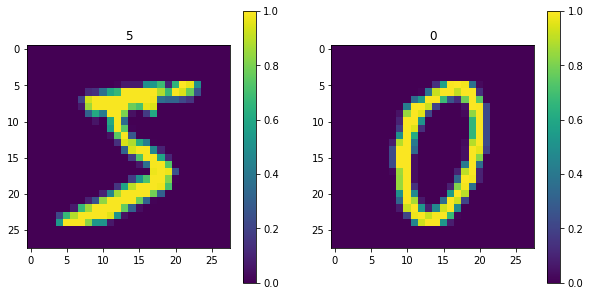

In [8]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(x_train[0].cpu())
plt.colorbar()
plt.title(y_train[0].cpu().item());
plt.subplot(1,2,2)
plt.imshow(x_train[1000].cpu())
plt.colorbar()
plt.title(y_train[1000].cpu().item());

# Tasks
* Train a classifier with fully-connected layers only.
* Train a classifier with convolutions only.
* Train a classifier with convolutions and fully-connected layers.
* Train a denoising network. Note, you have to create some noisy observations first ;)

# 1. Create model

In [9]:
class MyModel_FullyDense(nn.Module):
    def __init__(self):
        super(MyModel_FullyDense, self).__init__()
        self.dense1 = nn.Linear(28*28,32)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(32,10)
        self.softmax = nn.Softmax(1)

    def forward(self, x):
        x = self.dense1(x)
        x = self.relu(x)
        x = self.dense2(x)
        return self.softmax(x)

In [10]:
 class MyModel_FullyConv(nn.Module):
    def __init__(self):
        super(MyModel_FullyConv, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=3)       # 28-2 = 26
        self.conv2 = nn.Conv2d(10, 10, kernel_size=3)      # -2   = 24
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)  # /2   = 12
        self.conv3 = nn.Conv2d(10, 10, kernel_size=3)      # -2   = 10
        # - - - - - - - - - 
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)  # /2   = 5
        self.conv4 = nn.Conv2d(10, 10, kernel_size=5)      # -4   = 10
        self.flat  = nn.Flatten(start_dim=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = self.pool2(x)        
        x = F.relu(self.conv4(x))
        x = self.flat(x)
        return F.softmax(x,dim=1)

In [11]:
 class MyModel_Mixed(nn.Module):
    def __init__(self):
        super(MyModel_Mixed, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.softmax(x,dim=1)

# 2. Test if model runs

In [12]:
model_fdense = MyModel_FullyDense()
model_fdense.to(device)
model_fdense.eval()
model_fdense(x_train[0].flatten().unsqueeze(0))

tensor([[0.0964, 0.1141, 0.0979, 0.0864, 0.1156, 0.0933, 0.0906, 0.1083, 0.1032,
         0.0943]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [13]:
model_fconv = MyModel_FullyConv()
model_fconv.to(device)
model_fconv.eval()
model_fconv(x_train[0:1].unsqueeze(1))

tensor([[0.0977, 0.1004, 0.1041, 0.0977, 0.0991, 0.0977, 0.0977, 0.1021, 0.1020,
         0.1017]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [14]:
model_mixed = MyModel_Mixed()
model_mixed.to(device)
model_mixed.eval()
model_mixed(x_train[0:1].unsqueeze(1))

tensor([[0.0865, 0.1109, 0.0953, 0.0971, 0.1030, 0.1007, 0.0880, 0.1156, 0.1029,
         0.1001]], device='cuda:0', grad_fn=<SoftmaxBackward>)

# 3. Choose loss-function and optimizer

In [15]:
loss_function = F.nll_loss
optimizer_fdense = torch.optim.Adam(model_fdense.parameters(), lr=0.0001)
optimizer_fconv = torch.optim.Adam(model_fconv.parameters(), lr=0.0001)
optimizer_mixed = torch.optim.Adam(model_mixed.parameters(), lr=0.0001)

# 4. Write train-loop + train

__Note:__ If you want to train on GPU just call `model.cuda()` to move the model to GPU. Don't forget to move the training data to GPU as well. You can call `x.cuda()` to move a tensor to GPU.

In [16]:
def train(model, x, y, loss_function, optimizer, num_epochs):
    # Make sure that the model is in train-mode
    model.train()
    first = True
    
    running_loss = 0.0
    for e in tqdm(range(num_epochs)):
        for x_, y_ in zip(x, y):
            x_ = x_.unsqueeze(0)
            y_ = y_.unsqueeze(0)
            if first:
                print(x_.shape)
                print(y_.shape)
#                 first = False

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            y_hat = model(x_)
            if first:
#                 print(y_hat)
                print(y_hat.shape)
#                 first = False

            loss = loss_function(y_hat, y_)
            if first:
                print(loss)
                first = False

            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() # .item() returns the scalar value of the tensor.
            
        running_loss /= len(x)
        print('Epoch: %3d; Train-Loss: %.7f'%(e+1, running_loss))
        running_loss = 0.0

In [17]:
model_fdense.train()
train(model_fdense, x_train[:1000].flatten(start_dim=1), y_train, loss_function, optimizer_fdense, 10)

  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([1, 784])
torch.Size([1])
torch.Size([1, 10])
tensor(-0.0933, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch:   1; Train-Loss: -0.1552867
Epoch:   2; Train-Loss: -0.3228714
Epoch:   3; Train-Loss: -0.4691978
Epoch:   4; Train-Loss: -0.5696082
Epoch:   5; Train-Loss: -0.6229028
Epoch:   6; Train-Loss: -0.6612365
Epoch:   7; Train-Loss: -0.7075077
Epoch:   8; Train-Loss: -0.7362604
Epoch:   9; Train-Loss: -0.7591706
Epoch:  10; Train-Loss: -0.7816309


In [18]:
model_fconv.train()
train(model_fconv, x_train[:1000].unsqueeze(1), y_train, loss_function, optimizer_fconv, 10)

  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([1, 1, 28, 28])
torch.Size([1])
torch.Size([1, 10])
tensor(-0.0977, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch:   1; Train-Loss: -0.1022296
Epoch:   2; Train-Loss: -0.3893824
Epoch:   3; Train-Loss: -0.5632840
Epoch:   4; Train-Loss: -0.5862278
Epoch:   5; Train-Loss: -0.6019934
Epoch:   6; Train-Loss: -0.6119937
Epoch:   7; Train-Loss: -0.6242278
Epoch:   8; Train-Loss: -0.6330877
Epoch:   9; Train-Loss: -0.6385062
Epoch:  10; Train-Loss: -0.6425462


In [19]:
model_mixed.train()
train(model_mixed, x_train[:1000].unsqueeze(1), y_train, loss_function, optimizer_mixed, 10)

  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([1, 1, 28, 28])
torch.Size([1])
torch.Size([1, 10])
tensor(-0.1049, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch:   1; Train-Loss: -0.1026016
Epoch:   2; Train-Loss: -0.1676900
Epoch:   3; Train-Loss: -0.3310794
Epoch:   4; Train-Loss: -0.4175726
Epoch:   5; Train-Loss: -0.4968674
Epoch:   6; Train-Loss: -0.5145271
Epoch:   7; Train-Loss: -0.5740061
Epoch:   8; Train-Loss: -0.5970869
Epoch:   9; Train-Loss: -0.6290855
Epoch:  10; Train-Loss: -0.6387496


# 5. Evaluate

In [20]:
model_fdense.eval()
preds_fdense = model_fdense(x_train.flatten(start_dim=1))

In [21]:
model_fconv.eval()
preds_fconv = model_fconv(x_train.unsqueeze(1))

In [22]:
model_mixed.eval()
preds_mixed = model_mixed(x_train.unsqueeze(1))

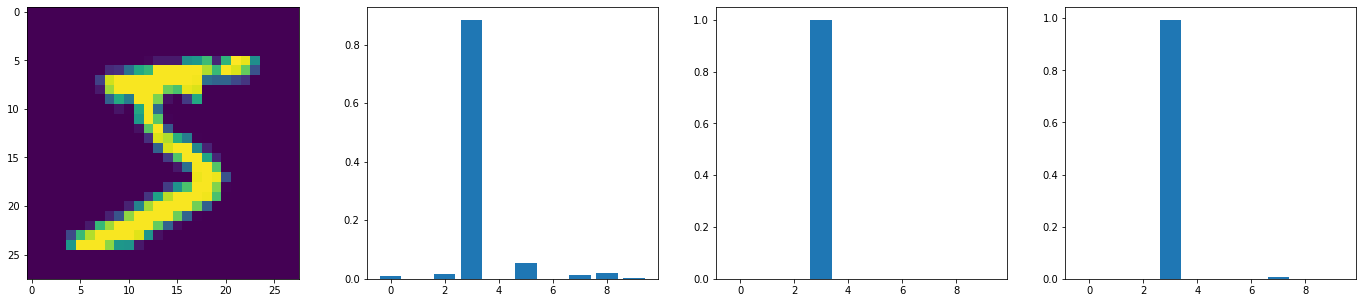

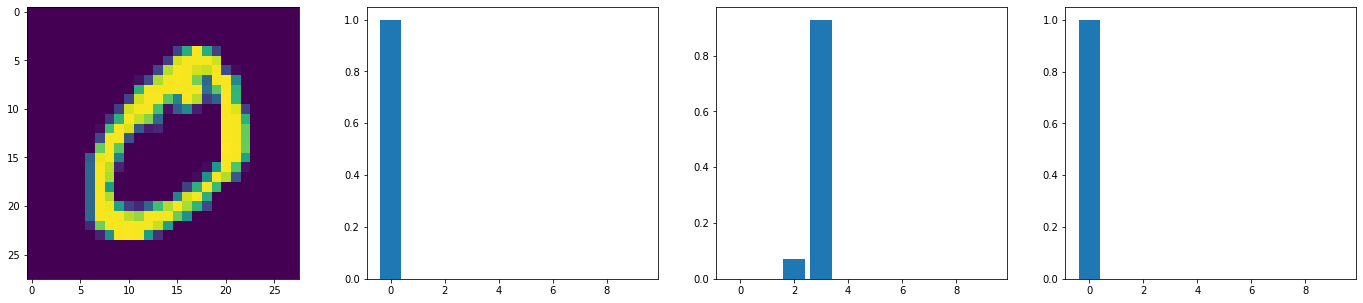

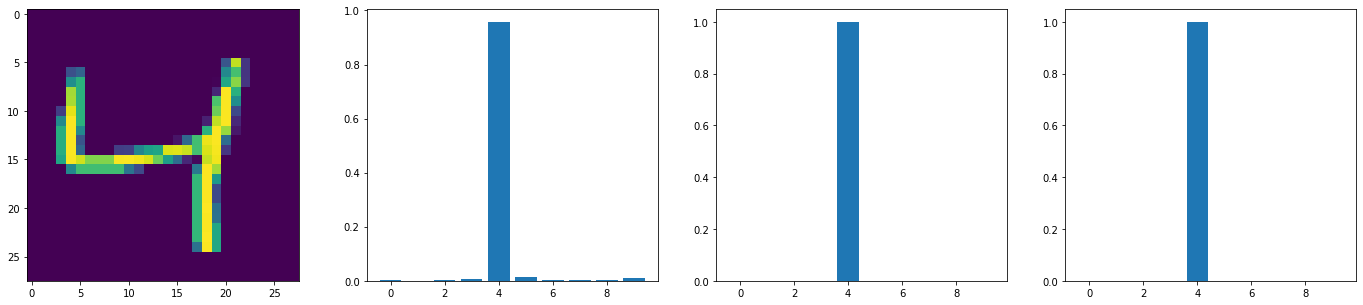

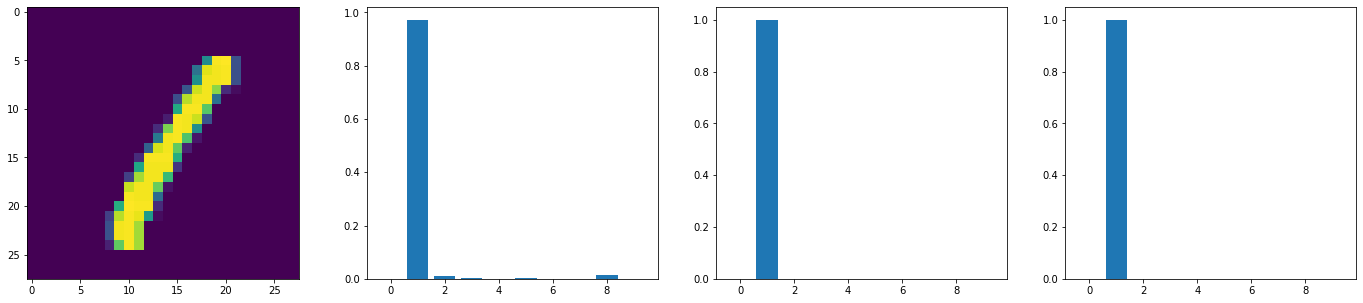

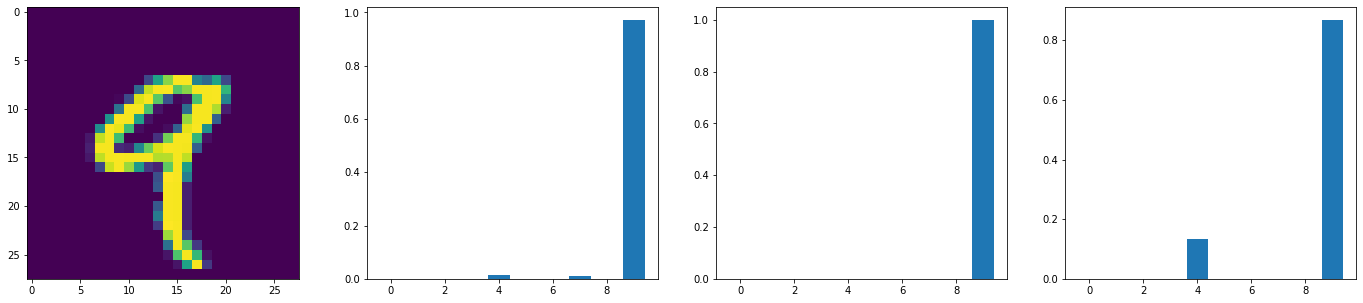

In [23]:
def plotarow(i,results):
    plt.figure(figsize=(8*len(results),5))
    plt.subplot(1,1+len(results),1)
    plt.imshow(x_train[i].cpu())
    for j in range(len(results)):
        plt.subplot(1,1+len(results),2+j)
        plt.bar([0,1,2,3,4,5,6,7,8,9],results[j].cpu().detach()[i])

for i in range(5):
    plotarow(i,[preds_fdense,preds_fconv,preds_mixed])

### Create Noisy Data

In [24]:
sig_train = x_train[:50000]
sig_test = x_train[50000:]

In [25]:
sig_train

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

In [26]:
def noise(imgs,sigma=.33):
    n = torch.from_numpy(np.array( np.random.normal(0, sigma, size=imgs.shape), dtype=np.float32))
    return imgs+n

    
noisy_train = noise(sig_train.cpu())
noisy_test = noise(sig_test.cpu())

In [27]:
noisy_train = noisy_train.to(device)
noisy_test = noisy_test.to(device)

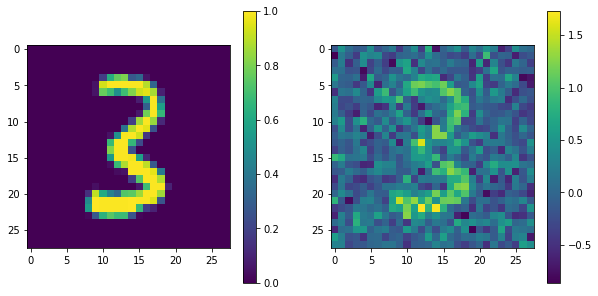

In [28]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(sig_test[0].cpu())
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(noisy_test[0].cpu())
plt.colorbar()

### Create Network

In [29]:
class MyModel_Denoise(nn.Module):
    def __init__(self):
        super(MyModel_Denoise, self).__init__()
        self.conv1 = nn.Conv2d(1, 10,  kernel_size=3, padding=(1,1))#, padding_mode='reflect')
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3, padding=(1,1))#, padding_mode='reflect')
        self.conv3 = nn.Conv2d(20, 1,  kernel_size=3, padding=(1,1))#, padding_mode='reflect')

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        return x

### Train

In [30]:
model_denoise = MyModel_Denoise()
model_denoise.to(device)
loss_denoise = F.mse_loss
optimizer_denoise = torch.optim.Adam(model_denoise.parameters(), lr=0.0001)
# optimizer_denoise = torch.optim.SGD(model_denoise.parameters(), lr=0.0001)

In [31]:
model_denoise.eval()
model_denoise(noisy_test[0:1].unsqueeze(0))

tensor([[[[7.1940e-03, 0.0000e+00, 4.5017e-02, 3.7103e-02, 7.7531e-03,
           1.8543e-02, 1.9697e-02, 4.7818e-03, 7.3547e-03, 5.0449e-02,
           1.5364e-03, 2.7853e-02, 5.9562e-02, 0.0000e+00, 6.2248e-02,
           0.0000e+00, 1.6335e-02, 2.5082e-03, 4.1191e-02, 7.3664e-03,
           6.0529e-02, 2.7156e-03, 4.6114e-02, 0.0000e+00, 1.3328e-02,
           9.7676e-03, 3.7381e-02, 6.7187e-02],
          [2.6943e-02, 0.0000e+00, 2.1898e-02, 6.8489e-03, 0.0000e+00,
           2.8142e-02, 0.0000e+00, 3.2347e-02, 1.4677e-02, 0.0000e+00,
           2.3630e-02, 1.7258e-02, 0.0000e+00, 1.1680e-02, 0.0000e+00,
           2.2041e-02, 0.0000e+00, 9.0208e-03, 0.0000e+00, 0.0000e+00,
           1.2008e-02, 0.0000e+00, 1.9057e-02, 3.0776e-02, 0.0000e+00,
           5.6418e-03, 0.0000e+00, 2.7980e-02],
          [0.0000e+00, 0.0000e+00, 5.3661e-03, 0.0000e+00, 0.0000e+00,
           2.4932e-03, 0.0000e+00, 2.5245e-02, 2.2652e-02, 0.0000e+00,
           0.0000e+00, 7.8004e-02, 0.0000e+00, 0.000

In [32]:
model_denoise.train()
train(model_denoise, noisy_train[:1000].unsqueeze(1), sig_train[:1000].unsqueeze(1), 
      loss_denoise, optimizer_denoise, 3)

  0%|          | 0/3 [00:00<?, ?it/s]

torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
tensor(0.1156, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch:   1; Train-Loss: 0.0199154
Epoch:   2; Train-Loss: 0.0086842
Epoch:   3; Train-Loss: 0.0079192


### Evaluate

In [33]:
model_denoise.eval()
denoised = model_denoise(noisy_test.unsqueeze(1).float())

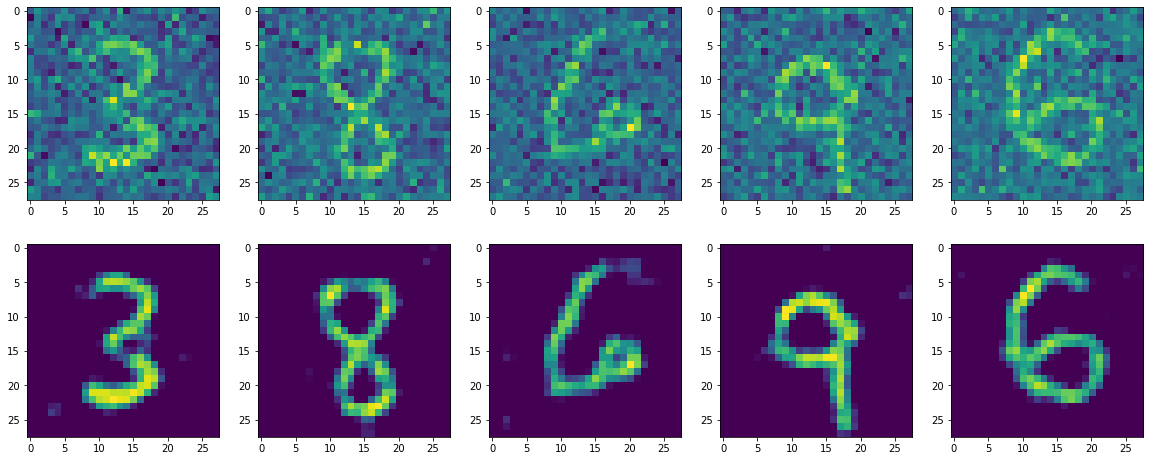

In [34]:
plt.figure(figsize=(20,8))
for i in range(5):
    plt.subplot(2,5,1+i)
    plt.imshow(noisy_test[i].cpu())
for i in range(5):
    plt.subplot(2,5,6+i)
    plt.imshow(denoised.cpu().detach().numpy()[i][0])